In [1]:
# %pip install nltk
# %pip install wordcloud
# %pip install --upgrade numpy
# %pip install --upgrade Pillow
# %pip install matplotlib
# %pip install textstat
# %pip install textblob

In [76]:
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import textstat
import string
import numpy as np
import torch

from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud
from gensim.models import Word2Vec, FastText

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from transformers import AutoModel, AutoTokenizer
from transformers import RobertaModel, RobertaTokenizer

In [3]:
warnings.filterwarnings('ignore')

In [4]:
dataset = pd.read_csv("../Data/fake_job_postings.csv")

In [5]:
dataset_fraud = dataset[dataset["fraudulent"] == 1]
dataset_non_fraud = dataset[dataset["fraudulent"] == 0]

### Analysing if Telecommuting is more prevalant for fradulent postings

No Telecommuting: 802
Telecommuting: 64
Percentage: 7.98005%


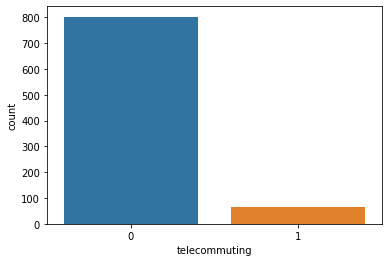

In [6]:
sns.countplot(data=dataset_fraud, x="telecommuting")
fraud_no_tele_count = dataset_fraud.telecommuting.value_counts()[0]
fraud_tele_count = dataset_fraud.telecommuting.value_counts()[1]
print(f"No Telecommuting: {fraud_no_tele_count}" )
print(f"Telecommuting: {fraud_tele_count}")
print(f"Percentage: {round(fraud_tele_count/fraud_no_tele_count * 100, 5)}%")

No Telecommuting: 16311
Telecommuting: 703
Percentage: 4.30997%


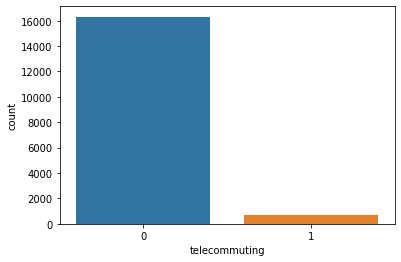

In [7]:
sns.countplot(data=dataset_non_fraud, x="telecommuting")
no_tele_count = dataset_non_fraud.telecommuting.value_counts()[0]
tele_count = dataset_non_fraud.telecommuting.value_counts()[1]
print(f"No Telecommuting: {no_tele_count}" )
print(f"Telecommuting: {tele_count}")
print(f"Percentage: {round(tele_count/no_tele_count * 100, 5)}%")

### Examing if lack of company logo is a good indicator for fraud

No Logo: 583
Have Logo: 283
Percentage: 206.00707%


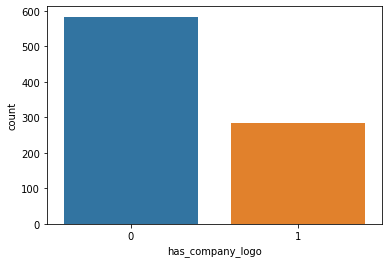

In [8]:
sns.countplot(data=dataset_fraud, x="has_company_logo")
fraud_no_logo_count = dataset_fraud.has_company_logo.value_counts()[0]
fraud_logo_count = dataset_fraud.has_company_logo.value_counts()[1]
print(f"No Logo: {fraud_no_logo_count}" )
print(f"Have Logo: {fraud_logo_count}")
print(f"Percentage: {round(fraud_no_logo_count/fraud_logo_count * 100, 5)}%")

No Logo: 3077
Have Logo: 13937
Percentage: 22.07792%


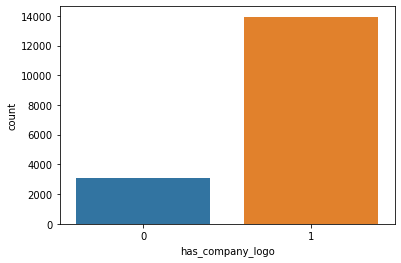

In [9]:
sns.countplot(data=dataset_non_fraud, x="has_company_logo")
no_logo_count = dataset_non_fraud.has_company_logo.value_counts()[0]
logo_count = dataset_non_fraud.has_company_logo.value_counts()[1]
print(f"No Logo: {no_logo_count}" )
print(f"Have Logo: {logo_count}")
print(f"Percentage: {round(no_logo_count/logo_count * 100, 5)}%")

### Title Analysis

In [10]:
def remove_special_characters(text):
    # Use a regular expression to match and replace special characters
    # In this example, we're removing anything that is not a letter or a space
    # You can modify the regex pattern to suit your needs
    return ''.join(e for e in text if e.isalpha() or e.isspace()).strip()

def remove_stopwords_lemm(dataset, column):
    eng_stopwords = set(stopwords.words("english"))
    lemm = WordNetLemmatizer()
    a = dataset[column].apply(word_tokenize)
    a = a.apply(lambda x: lemm.lemmatize(" ".join([word.lower() for word in x if word.lower() not in eng_stopwords])))
    return a

def remove_stopwords_pos(dataset, column):
    eng_stopwords = set(stopwords.words("english"))
    lemm = WordNetLemmatizer()
    dataset[column + "_tokenized"] = dataset[column].apply(word_tokenize)
    dataset[column + "_tokenized"] = dataset[column + "_tokenized"].apply(nltk.pos_tag)

def get_sentiment_score(text):
    analysis = TextBlob(text)
    # You can use the sentiment polarity or subjectivity as needed
    return analysis.sentiment.polarity

# Apply the function to the 'title' column
dataset_fraud['title'] = dataset_fraud['title'].apply(remove_special_characters)
dataset_non_fraud['title'] = dataset_non_fraud['title'].apply(remove_special_characters)

dataset_fraud["title_tokenized"] = remove_stopwords_lemm(dataset_fraud, "title")
dataset_non_fraud["title_tokenized"] = remove_stopwords_lemm(dataset_non_fraud, "title")



<AxesSubplot:>

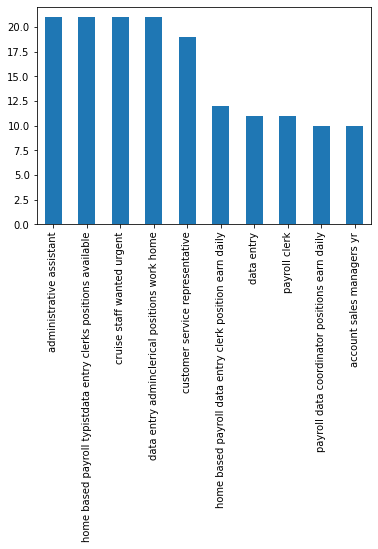

In [11]:
dataset_fraud.title_tokenized.value_counts().head(10).plot(kind ="bar")

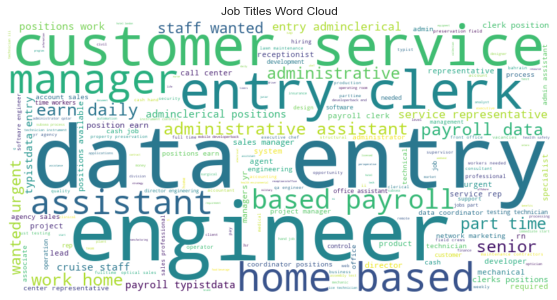

In [12]:
wordcloud_title_fraud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(dataset_fraud["title_tokenized"]))
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")  # Apply a seaborn style
plt.imshow(wordcloud_title_fraud, interpolation='bilinear')
plt.axis('off')
plt.title('Job Titles Word Cloud')
plt.show()

<AxesSubplot:>

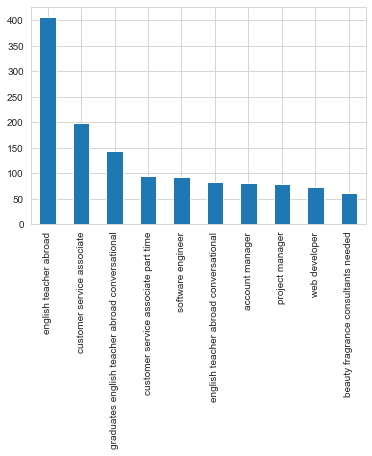

In [13]:
dataset_non_fraud.title_tokenized.value_counts().head(10).plot(kind ="bar")

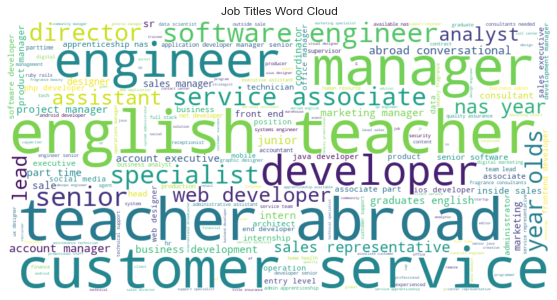

In [14]:
wordcloud_title_non_fraud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(dataset_non_fraud["title_tokenized"]))
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")  # Apply a seaborn style
plt.imshow(wordcloud_title_non_fraud, interpolation='bilinear')
plt.axis('off')
plt.title('Job Titles Word Cloud')
plt.show()

### Company Profile Analysis

<AxesSubplot:xlabel='company_profile', ylabel='count'>

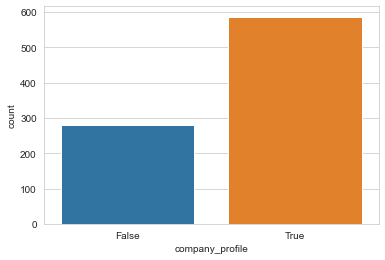

In [15]:
sns.countplot(data=dataset_fraud.isna(), x = "company_profile")

<AxesSubplot:xlabel='company_profile', ylabel='count'>

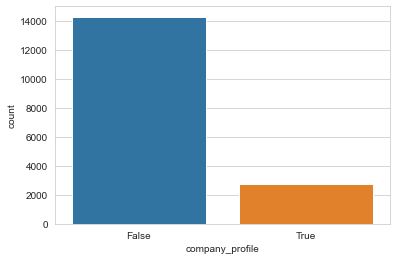

In [16]:
sns.countplot(data=dataset_non_fraud.isna(), x="company_profile")

In [17]:
dataset_fraud["company_profile"].fillna("", inplace=True)
dataset_non_fraud["company_profile"].fillna("", inplace=True)

dataset_fraud["company_profile"] = dataset_fraud["company_profile"].apply(remove_special_characters)
dataset_non_fraud["company_profile"] = dataset_non_fraud["company_profile"].apply(remove_special_characters)

dataset_fraud["company_profile_tokenized"] = remove_stopwords_lemm(dataset_fraud, "company_profile")
dataset_non_fraud["company_profile_tokenized"] = remove_stopwords_lemm(dataset_non_fraud, "company_profile")



In [18]:
dataset_fraud["company_profile_tokenized"]

98       staffing amp recruiting done right oil amp ene...
144                                                       
173      edison international refined resources partner...
180                                                       
215      staffing amp recruiting done right oil amp ene...
                               ...                        
17827                                                     
17828                                                     
17829                                                     
17830                                                     
17831    anthony warren marketing advertising consultan...
Name: company_profile_tokenized, Length: 866, dtype: object

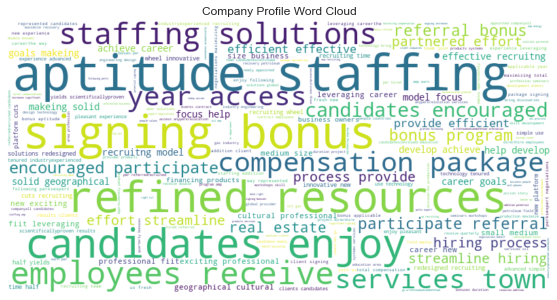

In [19]:
wordcloud_profile_fraud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(dataset_fraud["company_profile_tokenized"]))
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")  # Apply a seaborn style
plt.imshow(wordcloud_profile_fraud, interpolation='bilinear')
plt.axis('off')
plt.title('Company Profile Word Cloud')
plt.show()

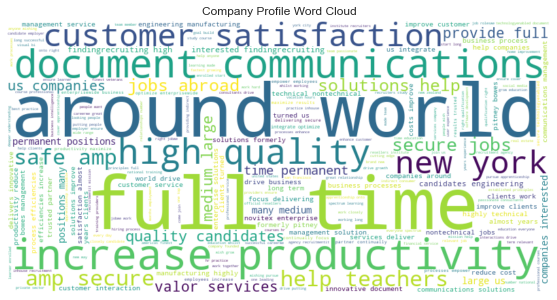

In [20]:
wordcloud_profile_non_fraud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(dataset_non_fraud["company_profile_tokenized"]))
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")  # Apply a seaborn style
plt.imshow(wordcloud_profile_non_fraud, interpolation='bilinear')
plt.axis('off')
plt.title('Company Profile Word Cloud')
plt.show()

#### Comprehension Difficulty (Dale Chall Score)

In [21]:
dataset_fraud['dale_chall_score'] = dataset_fraud['company_profile'].apply(lambda x: textstat.dale_chall_readability_score(x))
dataset_non_fraud['dale_chall_score'] = dataset_non_fraud['company_profile'].apply(lambda x: textstat.dale_chall_readability_score(x))

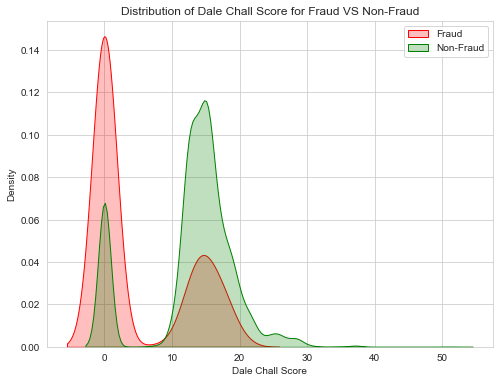

In [22]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=dataset_fraud["dale_chall_score"], label='Fraud', fill=True, color='red')
sns.kdeplot(data=dataset_non_fraud["dale_chall_score"], label='Non-Fraud', fill=True, color='green')

# Add labels and a legend
plt.xlabel('Dale Chall Score')
plt.ylabel('Density')
plt.title('Distribution of Dale Chall Score for Fraud VS Non-Fraud')
plt.legend()

# Show the plot
plt.show()

#### Readability Score (Flesch Reading Ease)

In [23]:
dataset_fraud['flesch_reading_ease'] = dataset_fraud['company_profile'].apply(lambda x: textstat.flesch_reading_ease(x))
dataset_non_fraud['flesch_reading_ease'] = dataset_non_fraud['company_profile'].apply(lambda x: textstat.flesch_reading_ease(x))

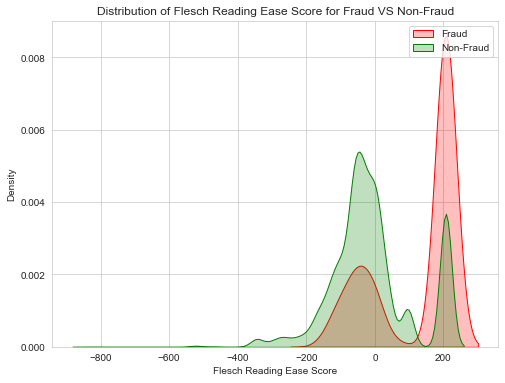

In [24]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=dataset_fraud["flesch_reading_ease"], label='Fraud', fill=True, color='red')
sns.kdeplot(data=dataset_non_fraud["flesch_reading_ease"], label='Non-Fraud', fill=True, color='green')

# Add labels and a legend
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Density')
plt.title('Distribution of Flesch Reading Ease Score for Fraud VS Non-Fraud')
plt.legend()

# Show the plot
plt.show()

#### Another Readability Test (Gunning Fog)

In [25]:
dataset_fraud['gunning_fog'] = dataset_fraud['company_profile'].apply(lambda x: textstat.gunning_fog(x))
dataset_non_fraud['gunning_fog'] = dataset_non_fraud['company_profile'].apply(lambda x: textstat.gunning_fog(x))

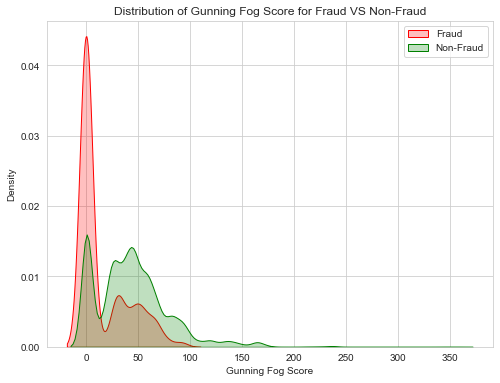

In [26]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=dataset_fraud["gunning_fog"], label='Fraud', fill=True, color='red')
sns.kdeplot(data=dataset_non_fraud["gunning_fog"], label='Non-Fraud', fill=True, color='green')

# Add labels and a legend
plt.xlabel('Gunning Fog Score')
plt.ylabel('Density')
plt.title('Distribution of Gunning Fog Score for Fraud VS Non-Fraud')
plt.legend()

# Show the plot
plt.show()

#### Average Length

In [27]:
dataset_fraud["company_profile_length"] = dataset_fraud["company_profile"].apply(lambda x: len(word_tokenize(x)))
dataset_non_fraud["company_profile_length"] = dataset_non_fraud["company_profile"].apply(lambda x: len(word_tokenize(x)))

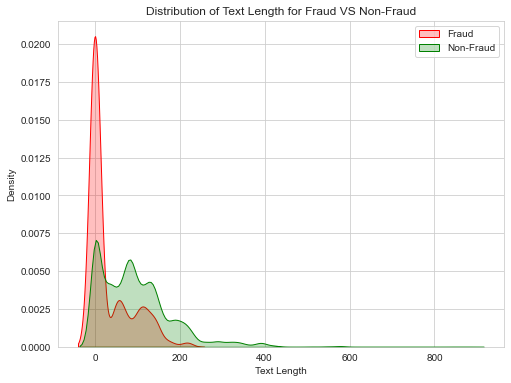

In [28]:
# Create density plots for text length distributions
plt.figure(figsize=(8, 6))
sns.kdeplot(data=dataset_fraud["company_profile_length"], label='Fraud', fill=True, color='red')
sns.kdeplot(data=dataset_non_fraud["company_profile_length"], label='Non-Fraud', fill=True, color='green')

# Add labels and a legend
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.title('Distribution of Text Length for Fraud VS Non-Fraud')
plt.legend()

# Show the plot
plt.show()

In [29]:
dataset_fraud["company_profile_sentiment"] = dataset_fraud['company_profile'].apply(get_sentiment_score)
dataset_non_fraud["company_profile_sentiment"] = dataset_non_fraud['company_profile'].apply(get_sentiment_score)

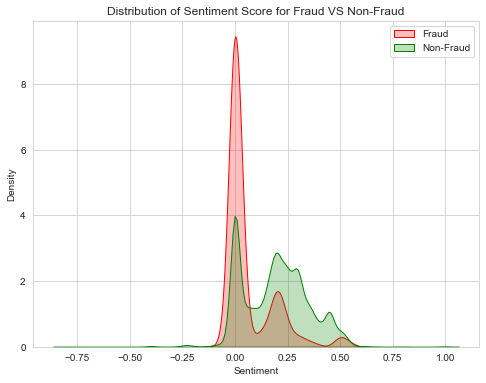

In [30]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=dataset_fraud["company_profile_sentiment"], label='Fraud', fill=True, color='red')
sns.kdeplot(data=dataset_non_fraud["company_profile_sentiment"], label='Non-Fraud', fill=True, color='green')

# Add labels and a legend
plt.xlabel('Sentiment')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Score for Fraud VS Non-Fraud')
plt.legend()

# Show the plot
plt.show()

In [31]:
# def clean_tokens(tokens):
#     tokens = [token for token in tokens if token not in string.punctuation]
#     tokens = [token for token in tokens if token.lower() not in set(stopwords.words("english"))]
#     return tokens

# fake_desc_tokens = dataset_fraud["company_profile"].apply(word_tokenize).apply(clean_tokens)
# fake_desc_tokens['trigrams'] = fake_desc_tokens.apply(lambda x: list(ngrams(x, 3)))

#get top 10 fake trigrams
# fake_3grams = [ngram for ngrams_list in fake_desc_tokens['trigrams'] for ngram in ngrams_list]
# fake_3grams_counts = Counter(fake_3grams)
# top_10_fake_3grams = fake_3grams_counts.most_common(10)
# for trigram, count in top_10_fake_3grams:
#     print(f"{trigram}: {count}")



In [32]:

# real_desc_tokens = dataset_non_fraud["company_profile"].apply(word_tokenize).apply(clean_tokens)
# real_desc_tokens['trigrams'] = real_desc_tokens.apply(lambda x: list(ngrams(x, 3)))

#get top 10 fake trigrams
# real_3grams = [ngram for ngrams_list in real_desc_tokens['trigrams'] for ngram in ngrams_list]
# real_3grams_counts = Counter(real_3grams)
# top_10_real_3grams = real_3grams_counts.most_common(10)
# for trigram, count in top_10_real_3grams:
#     print(f"{trigram}: {count}")

In [33]:
sentiment = SentimentIntensityAnalyzer()

dataset_fraud["company_profile_sentiment"] = dataset_fraud["company_profile"].apply(sentiment.polarity_scores)
dataset_non_fraud["company_profile_sentiment"] = dataset_non_fraud["company_profile"].apply(sentiment.polarity_scores)

In [34]:
dataset_fraud["Positive"] = list(map(lambda x: x['pos'], dataset_fraud["company_profile_sentiment"]))
dataset_fraud["Negative"] = list(map(lambda x: x['neg'], dataset_fraud["company_profile_sentiment"]))
dataset_fraud["Neutral"] = list(map(lambda x: x['neu'], dataset_fraud["company_profile_sentiment"]))
dataset_fraud["compound"] = list(map(lambda x: x['compound'], dataset_fraud["company_profile_sentiment"]))

dataset_non_fraud["Positive"] = list(map(lambda x: x['pos'], dataset_non_fraud["company_profile_sentiment"]))
dataset_non_fraud["Negative"] = list(map(lambda x: x['neg'], dataset_non_fraud["company_profile_sentiment"]))
dataset_non_fraud["Neutral"] = list(map(lambda x: x['neu'], dataset_non_fraud["company_profile_sentiment"]))
dataset_non_fraud["compound"] = list(map(lambda x: x['compound'], dataset_non_fraud["company_profile_sentiment"]))

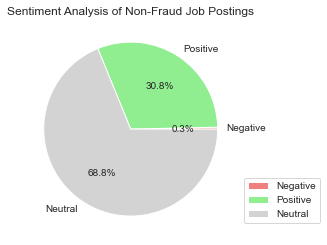

In [35]:
# visualize the distribution of sentiment category
senti_pie_count_list = []
senti_pie_count_list.append(len(dataset_fraud[dataset_fraud['compound'] < -0.05]))
senti_pie_count_list.append(len(dataset_fraud[dataset_fraud['compound'] > 0.05]))
senti_pie_count_list.append(len(dataset_fraud[(dataset_fraud['compound'] < 0.05) & (dataset_fraud['compound'] > -0.05)]))

colors = ['lightcoral', 'lightgreen', 'lightgrey']
labels = ["Negative","Positive","Neutral"]

plt.pie(np.array(senti_pie_count_list),labels = labels, colors = colors,autopct='%1.1f%%')
plt.title("Sentiment Analysis of Non-Fraud Job Postings")
plt.legend(bbox_to_anchor=(1, 0.3))
plt.show()

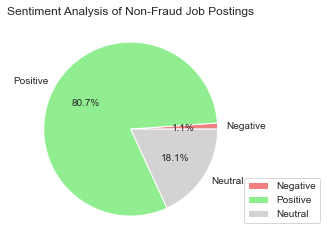

In [36]:
# visualize the distribution of sentiment category
senti_pie_count_list = []
senti_pie_count_list.append(len(dataset_non_fraud[dataset_non_fraud['compound'] < -0.05]))
senti_pie_count_list.append(len(dataset_non_fraud[dataset_non_fraud['compound'] > 0.05]))
senti_pie_count_list.append(len(dataset_non_fraud[(dataset_non_fraud['compound'] < 0.05) & (dataset_non_fraud['compound'] > -0.05)]))

colors = ['lightcoral', 'lightgreen', 'lightgrey']
labels = ["Negative","Positive","Neutral"]

plt.pie(np.array(senti_pie_count_list),labels = labels, colors = colors,autopct='%1.1f%%')
plt.title("Sentiment Analysis of Non-Fraud Job Postings")
plt.legend(bbox_to_anchor=(1, 0.3))
plt.show()